In [3]:
import pandas as pd

df=pd.read_csv('/Users/junyefan/Desktop/Graduate/Course/2025_Spring/MGTA_495_Marketing_Analytics/Week1/quartosite/HW1/project3/conjoint_data.csv')

# Convert categorical variables into dummy variables
df['brand'] = df['brand'].astype(str)
df['ad'] = df['ad'].astype(str)

# Create dummies for brand (Hulu as reference)
brand_dummies = pd.get_dummies(df['brand'], prefix='brand')
brand_dummies.drop(columns=['brand_H'], inplace=True)

# Convert ad to binary: Yes = 1, No = 0
df['ad_binary'] = df['ad'].map({'Yes': 1, 'No': 0})

# Combine into feature matrix
X = pd.concat([
    df[['resp', 'task', 'choice', 'price']],
    brand_dummies,
    df['ad_binary']
], axis=1)

# Rename for clarity
X.rename(columns={
    'brand_N': 'brand_netflix',
    'brand_P': 'brand_prime'
}, inplace=True)

# Final structure
X = X[['resp', 'task', 'choice', 'brand_netflix', 'brand_prime', 'ad_binary', 'price']]

In [4]:
X

,resp,task,choice,brand_netflix,brand_prime,ad_binary,price
0,1,1,1,True,False,1,28
1,1,1,0,False,False,1,16
2,1,1,0,False,True,1,16
3,1,2,0,True,False,1,32
4,1,2,1,False,True,1,16
...,...,...,...,...,...,...,...
2995,100,9,1,False,False,0,12
2996,100,9,0,False,True,1,8
2997,100,10,0,True,False,1,28
2998,100,10,0,False,False,0,24


In [6]:
import numpy as np
from scipy.optimize import minimize

# Define input variables for estimation
X_vars = ['brand_netflix', 'brand_prime', 'ad_binary', 'price']
X_mat = X[X_vars].values
y = X['choice'].values

# Group each choice set (task within respondent) for probability denominator
group_ids = X.groupby(['resp', 'task']).ngroup().values

# Define the negative log-likelihood function
def neg_log_likelihood(beta):
    utilities = X_mat @ beta
    df_temp = pd.DataFrame({
        'group': group_ids,
        'utility': utilities,
        'choice': y
    })
    df_temp['exp_u'] = np.exp(df_temp['utility'].astype(float))

    # Compute denominator of softmax per choice set
    group_sums = df_temp.groupby('group')['exp_u'].transform('sum')
    df_temp['log_prob'] = df_temp['utility'] - np.log(group_sums)

    # Only keep log probabilities of chosen alternatives
    chosen_log_probs = df_temp[df_temp['choice'] == 1]['log_prob']
    return -np.sum(chosen_log_probs)

# Initial parameter guess
beta_init = np.zeros(X_mat.shape[1])

# Minimize the negative log-likelihood
result = minimize(neg_log_likelihood, beta_init, method='BFGS')

# Extract results
beta_hat = result.x
hessian_inv = result.hess_inv
standard_errors = np.sqrt(np.diag(hessian_inv))

# Construct 95% confidence intervals
z = 1.96
conf_int = np.vstack([beta_hat - z * standard_errors, beta_hat + z * standard_errors]).T

# Combine into a summary table
param_names = ['beta_netflix', 'beta_prime', 'beta_ads', 'beta_price']
mle_summary = pd.DataFrame({
    'parameter': param_names,
    'estimate': beta_hat,
    'std_error': standard_errors,
    'ci_lower': conf_int[:, 0],
    'ci_upper': conf_int[:, 1]
})

mle_summary.round(4)

,parameter,estimate,std_error,ci_lower,ci_upper
0,beta_netflix,0.9412,1.4043,-1.8112,3.6936
1,beta_prime,0.5016,1.6607,-2.7534,3.7566
2,beta_ads,-0.7320,0.3449,-1.4080,-0.0560
3,beta_price,-0.0995,0.0084,-0.1160,-0.0830


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reuse log-likelihood function from earlier
def log_likelihood(beta):
    utilities = X_mat @ beta
    df_temp = pd.DataFrame({
        'group': group_ids,
        'utility': utilities,
        'choice': y
    })
    df_temp['exp_u'] = np.exp(pd.to_numeric(df_temp['utility'], errors='coerce'))
    group_sums = df_temp.groupby('group')['exp_u'].transform('sum')
    df_temp['log_prob'] = df_temp['utility'] - np.log(group_sums)
    return np.sum(df_temp[df_temp['choice'] == 1]['log_prob'])

# Log-prior function
def log_prior(beta):
    return (
        -0.5 * (beta[0]**2 + beta[1]**2 + beta[2]**2) / 25  # N(0, 5^2)
        -0.5 * (beta[3]**2)  # N(0, 1^2) for price
    )

# Log-posterior
def log_posterior(beta):
    return log_likelihood(beta) + log_prior(beta)

# Proposal step: N(0, diag(...))
proposal_sd = np.array([0.05, 0.05, 0.05, 0.005])

# MCMC settings
n_steps = 11000
beta_draws = np.zeros((n_steps, 4))
beta_current = np.zeros(4)
log_post_current = log_posterior(beta_current)

# Run Metropolis-Hastings
for t in range(1, n_steps):
    beta_proposal = beta_current + np.random.normal(0, proposal_sd)
    log_post_proposal = log_posterior(beta_proposal)
    accept_ratio = np.exp(log_post_proposal - log_post_current)

    if np.random.rand() < accept_ratio:
        beta_current = beta_proposal
        log_post_current = log_post_proposal

    beta_draws[t, :] = beta_current

# Drop first 1000 draws (burn-in)
posterior_samples = beta_draws[1000:, :]

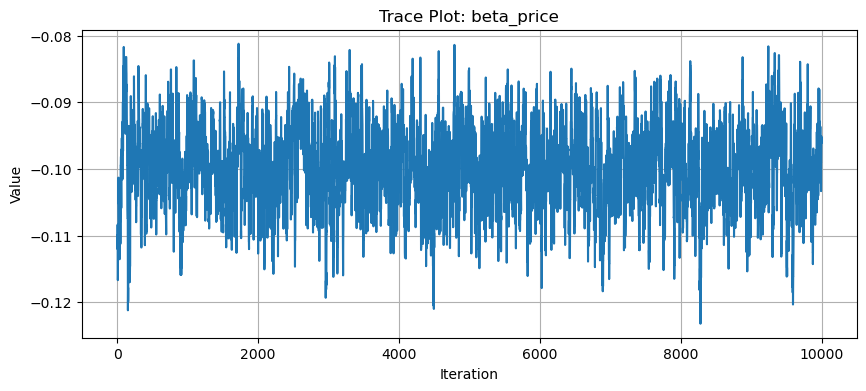

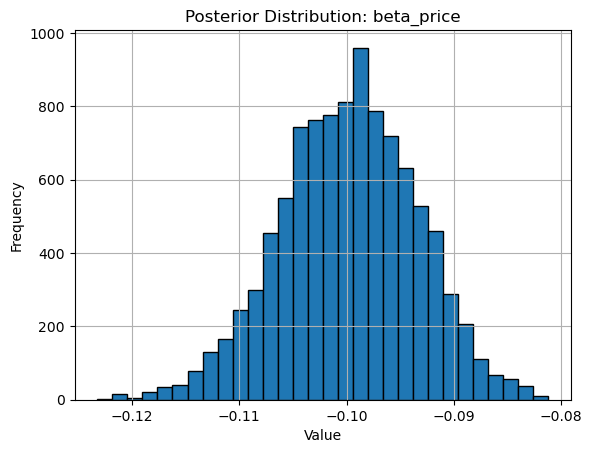

,mean,std,2.5%,97.5%
beta_netflix,0.9427,0.1096,0.7156,1.1490
beta_prime,0.5026,0.1060,0.2870,0.7043
beta_ads,-0.7316,0.0885,-0.9113,-0.5526
beta_price,-0.0998,0.0064,-0.1127,-0.0879


In [9]:

param_names = ['beta_netflix', 'beta_prime', 'beta_ads', 'beta_price']

# Trace plot for beta_price
plt.figure(figsize=(10, 4))
plt.plot(posterior_samples[:, 3])
plt.title("Trace Plot: beta_price")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.grid(True)
plt.show()

# Histogram for beta_price
plt.hist(posterior_samples[:, 3], bins=30, edgecolor='k')
plt.title("Posterior Distribution: beta_price")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Summary statistics
posterior_df = pd.DataFrame(posterior_samples, columns=param_names)
posterior_summary = posterior_df.describe(percentiles=[0.025, 0.975]).T
posterior_summary['mean'] = posterior_df.mean()
posterior_summary['std'] = posterior_df.std()
posterior_summary['2.5%'] = posterior_df.quantile(0.025)
posterior_summary['97.5%'] = posterior_df.quantile(0.975)

posterior_summary[['mean', 'std', '2.5%', '97.5%']].round(4)

In [10]:
import matplotlib.pyplot as plt

param_names = ['beta_netflix', 'beta_prime', 'beta_ads', 'beta_price']

# Use a consistent style
plt.style.use('seaborn-whitegrid')

# 🎯 Trace plot for beta_price
plt.figure(figsize=(10, 4))
plt.plot(posterior_samples[:, 3], color='royalblue', linewidth=1)
plt.title("Trace Plot: beta_price", fontsize=14)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# 🎯 Histogram for beta_price
plt.figure(figsize=(8, 4))
plt.hist(posterior_samples[:, 3], bins=30, color='lightcoral', edgecolor='black')
plt.title("Posterior Distribution: beta_price", fontsize=14)
plt.xlabel("Value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

OSError: 'seaborn-whitegrid' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

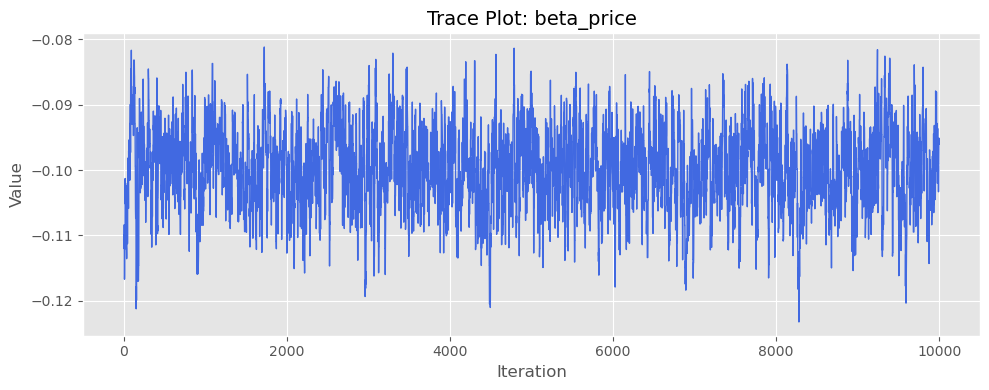

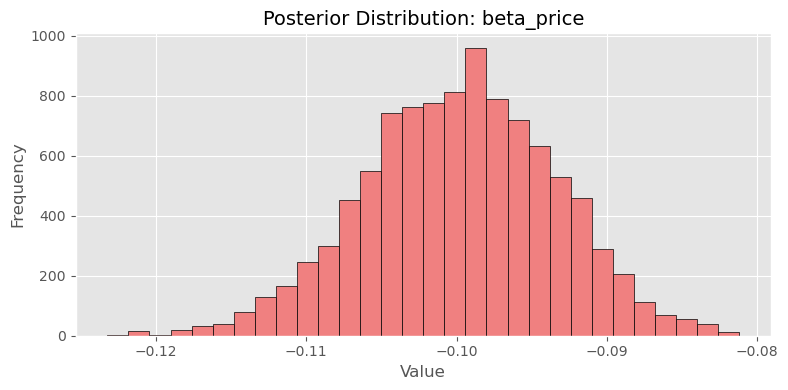

In [11]:
import matplotlib.pyplot as plt

# 使用 matplotlib 内置可用样式
plt.style.use('ggplot')  # 或 'bmh', 'classic', 'seaborn-v0_8-whitegrid'

# Trace plot
plt.figure(figsize=(10, 4))
plt.plot(posterior_samples[:, 3], color='royalblue', linewidth=1)
plt.title("Trace Plot: beta_price", fontsize=14)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Histogram
plt.figure(figsize=(8, 4))
plt.hist(posterior_samples[:, 3], bins=30, color='lightcoral', edgecolor='black')
plt.title("Posterior Distribution: beta_price", fontsize=14)
plt.xlabel("Value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
posterior_summary[['mean', 'std', '2.5%', '97.5%']] 

,mean,std,2.5%,97.5%
beta_netflix,0.942666,0.109552,0.715553,1.149033
beta_prime,0.502566,0.105952,0.287028,0.704273
beta_ads,-0.731626,0.088473,-0.911344,-0.552625
beta_price,-0.099829,0.006369,-0.112747,-0.087856
